# plot

> Collection of plotting functions.

In [ ]:
# | default_exp plot


In [ ]:
# | hide
from nbdev.showdoc import *

from fastcore.test import *
from fastcore.docments import docments


In [ ]:
# | export
import pickle
import os

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
from samap.mapping import SAMAP

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from plotly.subplots import make_subplots

from comandos import util


## See the big picture

These functions are intended to help you find your way around the data. I use them a lot when
generating reports for collaborators, to set the stage for the more detailed analyses. In
particular, I want to highlight which clusters we are comparing and where they are in the context of
both species as well as the comparison.

In [ ]:
# | export
def highlighted_dimplot(
    adata,
    species,
    clustering,
    cluster,
    embedding="X_umap",
    highlight="red",
    figsize=(10, 10),
    save=None,
):
    """
    Plot a low-dimensional embedding and highlight a chosen cluster with a superimposed circle.

    Parameters
    ----------
    adata : anndata.AnnData
        AnnData object to plot.
    species : str
        Species name. Will be used in the title, and removed from the cluster names if present.
    clustering : str
        Clustering to plot. Must be present in `adata.obs`.
    cluster : str
        Cluster to highlight.
    embedding : str, optional
        Embedding to plot (default: "X_umap").
    highlight : str, optional
        Color of the circle (default: "red").
    figsize : tuple, optional
        Figure size (default: (10, 10)).
    save : str, optional
        Path to save the figure (default: None).

    Returns
    -------
    None
    """
    cluster_cells = adata.obs[clustering] == cluster.replace(species + "_", "")
    coords = adata.obsm[embedding][cluster_cells]
    cx, cy = util.find_center(coords)
    radius = np.mean(np.std(coords, axis=0))
    if radius < 0.5:
        radius = 0.5
    elif radius > 2:
        radius = 2
    _fig, ax = plt.subplots(figsize=figsize)
    g = sc.pl.embedding(
        adata,
        basis=embedding,
        color=clustering,
        legend_loc="on data",
        ax=ax,
        show=False,
        title=species,
    )
    g.axes.add_patch(
        Circle((cx, cy), radius, linewidth=3, facecolor="none", edgecolor=highlight)
    )
    g.set_title(species)
    if save is not None:
        plt.savefig(save)


In [ ]:
planarian = sc.read_h5ad("../example_data/planarian.h5ad")


/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


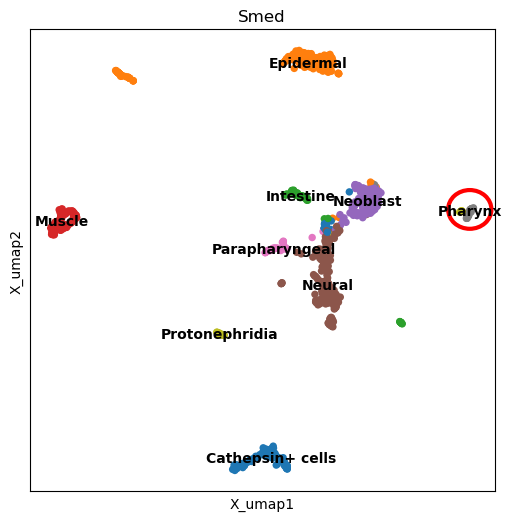

In [ ]:
highlighted_dimplot(planarian, "Smed", "tissue", "Pharynx", figsize=(6, 6))


Of course, if a cluster is too spread out, the plot will not work as well, but it will still be
useful to see the general location of the cluster.

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


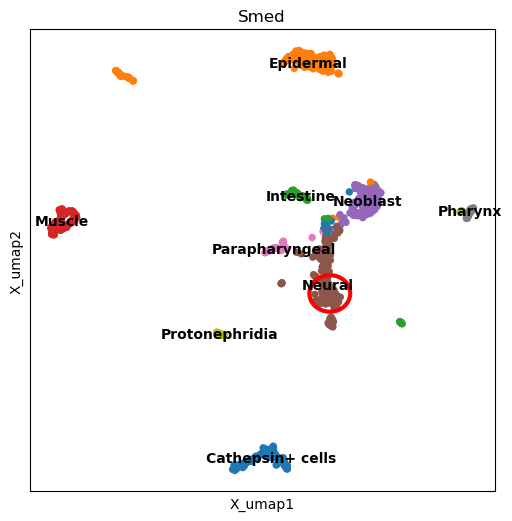

In [ ]:
highlighted_dimplot(planarian, "Smed", "tissue", "Neural", figsize=(6, 6))


Another case that might not work so well is if the shape of a cluster is not Gaussian. Still, it
should help us spot the cluster, especially if the color contrasts enough.

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


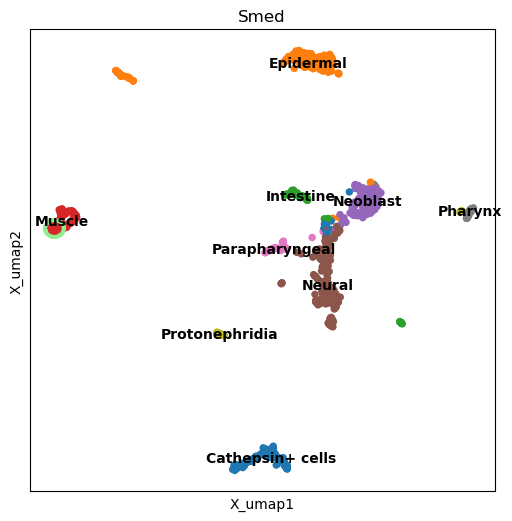

In [ ]:
highlighted_dimplot(
    planarian, "Smed", "tissue", "Muscle", figsize=(6, 6), highlight="lightgreen"
)


In [ ]:
# | exporti
def _plot_clustermap(
    similarity,
    query_map,
    target_map,
    query_handles,
    target_handles,
    query_lut,
    target_lut,
    query_species,
    target_species,
    query_clustering,
    target_clustering,
    query_coarse,
    target_coarse,
    figsize,
    save,
):
    if figsize is None:
        figsize = np.array(similarity.shape) / 3

    sns.clustermap(
        similarity,
        cmap="magma_r",
        figsize=figsize,
        col_cluster=None,
        row_cluster=None,
        dendrogram_ratio=0.1,
        colors_ratio=0.02,
        cbar_pos=(0.04, 0.75, 0.02, 0.15),
        row_colors=target_map.set_index(target_clustering)[target_coarse],
        col_colors=query_map.set_index(query_clustering)[query_coarse],
        linecolor="black",
        linewidths=0.5,
    )

    query_legend = plt.legend(
        query_handles,
        query_lut,
        title=f"{query_species}\nmajor cell types",
        bbox_to_anchor=(0.07, 0.7),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )
    plt.gca().add_artist(query_legend)

    plt.legend(
        target_handles,
        target_lut,
        title=f"{target_species}\nmajor cell types",
        bbox_to_anchor=(0.06, 0.5),
        bbox_transform=plt.gcf().transFigure,
        loc="upper right",
    )

    if save is not None:
        plt.savefig(save)

In [ ]:
# | exporti
def _plotly_clustermap(
    similarity,
    query_map,
    target_map,
    query_clustering,
    target_clustering,
    query_coarse,
    target_coarse,
    figsize,
    save,
    dpi=300,
):
    query_colors = query_map.set_index(query_clustering)
    query_colors["cc"] = pd.Categorical(query_colors[query_coarse])
    query_colors["code"] = query_colors.cc.cat.codes
    # query_info = query_colors.drop(columns=["code", "cc"]).loc[similarity.columns]
    query_info = query_map.set_index("Cluster").loc[similarity.columns]
    query_colors = query_colors.drop(columns=[query_coarse, "cc"]).loc[
        similarity.columns
    ]

    target_colors = target_map.set_index(target_clustering)
    target_colors["cc"] = pd.Categorical(target_colors[target_coarse])
    target_colors["code"] = target_colors.cc.cat.codes
    target_info = target_colors.drop(columns=["code", "cc"]).loc[similarity.index]
    target_colors = target_colors.drop(columns=[target_coarse, "cc"]).loc[
        similarity.index
    ]

    make_subplots(
        rows=2,
        cols=2,
        column_widths=[0.95, 0.05],
        row_heights=[0.95, 0.05],
        vertical_spacing=0.02,
        shared_xaxes=True,
        shared_yaxes=True,
    )

    data_heatmap = go.Heatmap(
        z=similarity.T, x=similarity.index, y=similarity.columns, colorscale="magma_r"
    )

    query_annot = go.Heatmap(
        z=query_colors.loc[similarity.columns],
        text=query_info,
        hoverinfo="text",
        colorscale="Rainbow",
        showscale=False,
        xaxis="x2",
        yaxis="y",
    )
    target_annot = go.Heatmap(
        z=target_colors.loc[similarity.index].T,
        text=target_info.T,
        hoverinfo="text",
        colorscale="Rainbow",
        showscale=False,
        xaxis="x",
        yaxis="y2",
    )

    data = [data_heatmap, query_annot, target_annot]

    layout = go.Layout(
        xaxis=dict(domain=[0, 0.95]),
        yaxis=dict(domain=[0, 0.95]),
        xaxis2=dict(domain=[0.95, 1], showticklabels=False),
        yaxis2=dict(domain=[0.95, 1], showticklabels=False),
    )
    fig = go.Figure(data=data, layout=layout)

    if figsize is not None:
        fig.update_layout(width=figsize[0] * dpi, height=figsize[1] * dpi)

    if save is not None:
        fig.write_html(save + ".html")
        fig.write_json(save + ".json")

    fig.show()

In [ ]:
# | export
def plot_overview(
    sm,
    similarity,
    query_species,
    target_species,
    query_clustering,
    target_clustering,
    query_coarse=None,
    target_coarse=None,
    interactive=False,
    figsize=None,
    save=None,
    **kwargs,
):
    """
    Plot the similarity matrix as an annotated heatmap.

    Parameters
    ----------
    sm : samap.mapping.SAMAP
        SAMAP object.
    similarity : pandas.DataFrame
        Similarity matrix. Contains query species clusters as columns and target species clusters as
        rows.
    query_species : str
        Query species ID. Will be used in the title. Should prepend the similarity matrix column
        names.
    target_species : str
        Target species ID. Will be used in the title. Should prepend the similarity matrix row
        names.
    query_clustering : str
        Query species clustering. Must be present in `sm.sams[query_species].adata.obs`.
    target_clustering : str
        Target species clustering. Must be present in `sm.sams[target_species].adata.obs`.
    query_coarse : str, optional
        Query species coarse clustering. Must be present in `sm.sams[query_species].adata.obs`. If
        None, will be set to `query_clustering` (default: None).
    target_coarse : str, optional
        Target species coarse clustering. Must be present in `sm.sams[target_species].adata.obs`. If
        None, will be set to `target_clustering` (default: None).
    interactive : bool, optional
        If True, will plot an interactive `plotly` figure; otherwise, a `seaborn.clustermap`
        (default: False).
    figsize : tuple, optional
        Figure size. If `interactive=False` will be the absolute figure size in inches. If
        `interactive=False`, will b (default: None).
    save : str, optional
        Path to save the figure (default: None).
    **kwargs
        Keyword arguments passed to `seaborn.clustermap` or `plotly.graph_objects.Figure`. Among
        them: dpi (int), which is only used if `interactive=True` to set the figure size in pixels.
    """
    if query_coarse is None:
        query_coarse = query_clustering
    if target_coarse is None:
        target_coarse = target_clustering

    query_map, query_lut, query_handles = util.map_fine_to_coarse(
        sm, query_species, query_clustering, query_coarse
    )
    target_map, target_lut, target_handles = util.map_fine_to_coarse(
        sm, target_species, target_clustering, target_coarse
    )

    query_map[query_coarse] = query_map[query_coarse].replace(to_replace=query_lut)
    target_map[target_coarse] = target_map[target_coarse].replace(to_replace=target_lut)

    if not interactive:
        _plot_clustermap(
            similarity,
            query_map,
            target_map,
            query_handles,
            target_handles,
            query_lut,
            target_lut,
            query_species,
            target_species,
            query_clustering,
            target_clustering,
            query_coarse,
            target_coarse,
            figsize,
            save,
            **kwargs,
        )
    else:
        _plotly_clustermap(
            similarity,
            query_map,
            target_map,
            query_clustering,
            target_clustering,
            query_coarse,
            target_coarse,
            figsize,
            save,
            **kwargs,
        )

Read the requisite files: the SAMap object and the pairwise cluster similarity matrix.

In [ ]:
file = open("../example_data/hypl.pkl", "rb")
sm = pickle.load(file)

hypl = pd.read_csv("../example_data/hypl_similarity_table.csv", index_col=0)


First improve the coarse level assignments for the data we have here:

In [ ]:
sm.sams["hy"].adata.obs["coarse"] = (
    sm.sams["hy"].adata.obs["Cluster"].str.split("_").str[0]
)
sm.sams["pl"].adata.obs["coarse"] = (
    sm.sams["pl"].adata.obs["tissue_smedwi"].str.split("_").str[0]
)


/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


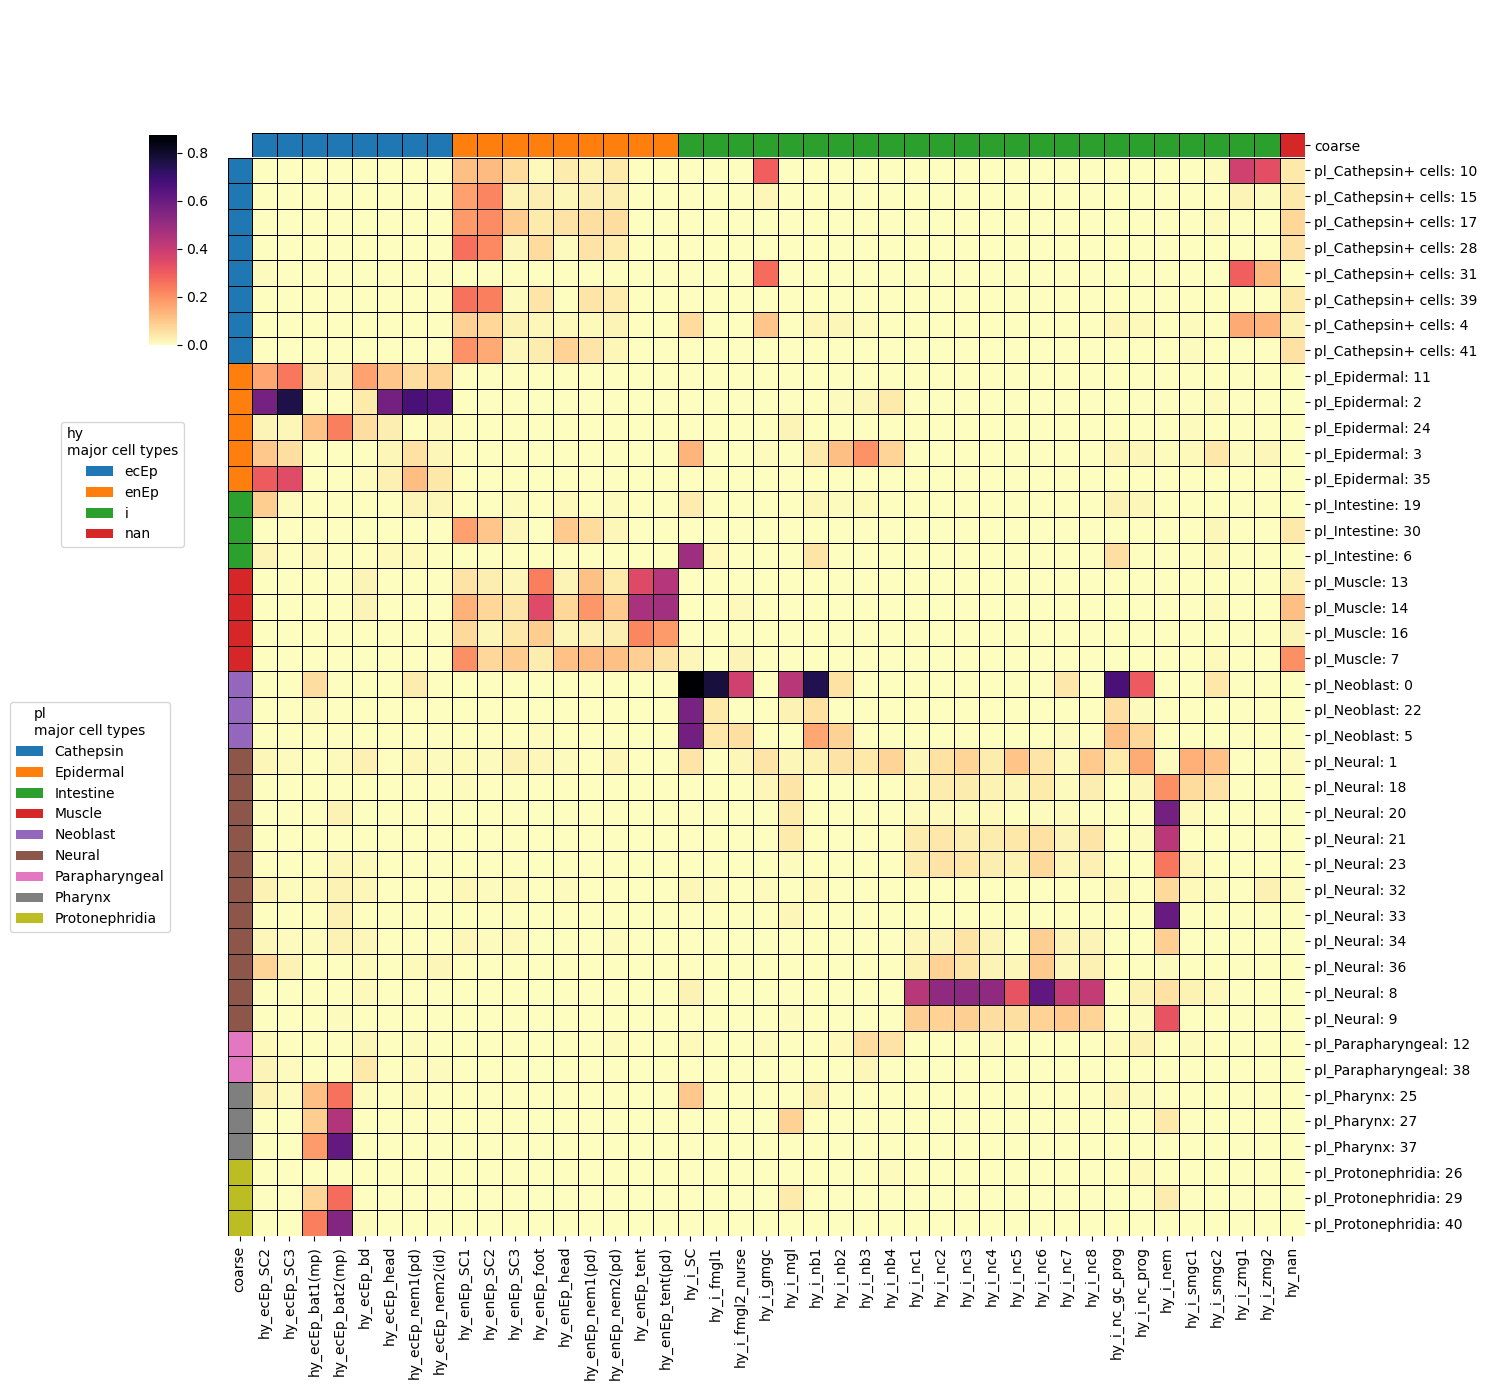

In [ ]:
plot_overview(
    sm,
    hypl,
    "hy",
    "pl",
    query_clustering="Cluster",
    target_clustering="cluster",
    query_coarse="coarse",
    target_coarse="coarse",
    interactive=False,
    save="hypl.pdf",
)


This sort of plot does a much better job of showing the relationships between clusters than the
Sankey diagram. Clear patches of similarity emerge that would be otherwise invisible. This is a
result of the hierarchical relationship between cell types (see Arendt/Musser/Wagner in
[2016](https://www.nature.com/articles/nrg.2016.127) and
[2019](https://www.sciencedirect.com/science/article/pii/S0959438819300194)). By combining maps like
this with the per-species cell type family trees we can start to get a better idea of how cell types
may have evolved over time.

In [ ]:
assert os.path.exists("hypl.pdf")

We can make the same plot in interactive form. Unfortunately, the interactive version is a bit more
finicky with color usage, so for now I'll let `plotly` choose the colors, but any `plotly` wizards
out there are welcome to improve this. Right now hovering over a point will show the cluster names
and SAMap score; hovering over the colored bars at the margins should show the coarse cluster.

In [ ]:
plot_overview(
    sm,
    hypl,
    "hy",
    "pl",
    query_clustering="Cluster",
    target_clustering="cluster",
    query_coarse="coarse",
    target_coarse="coarse",
    figsize=(10, 10),
    interactive=True,
    dpi=100,
    save="hypl",
)

/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/comandos/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


For some reason the cell type names are not showing up in the hover text. I'm not sure why, but this
is a TODO.

In [ ]:
assert os.path.exists("hypl.json")
assert os.path.exists("hypl.html")

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()
